# Preparing working environnment

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
# Import dataset
data = pd.read_csv('/content/drive/My Drive/DS_projet6/flipkart_com-ecommerce_sample_1050.csv')
data = data[['uniq_id', 'product_category_tree', 'image']]

# Retrieving categories
df_categ = data['product_category_tree'].str.split(pat = '>>', expand = True)
df_categ[0] = df_categ[0].apply(lambda x: str(x)[2:] if str(x)[:2] == '["' else x)

for c in np.arange(0,7,1):
    df_categ[c] = df_categ[c].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '"]' else x)
    
data = data.join(df_categ.iloc[:,:2])
data.rename(columns = {0 : 'category', 1 : 'subcategory'}, inplace = True)
data.drop(columns = 'product_category_tree', inplace = True)

# CNN on Black & White images

### Data preprocessing

In [22]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input

save_path = '/content/drive/My Drive/DS_projet6/Edited_Images_NB/'

# Creating image collection
for i in range(len(data)):
    img = load_img(save_path + data['image'][i], target_size=(300, 300))
    img = img_to_array(img)
    
    if i == 0:
        img_collec = img
    else:
        img_collec = np.append(img_collec, img)

img_collec = img_collec.reshape((len(data), 300, 300, 3))

In [23]:
# Train - test split
from sklearn.model_selection import train_test_split

y_ = pd.get_dummies(data['category'])
X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(img_collec, y_, test_size = 0.3)

### Creating model

In [24]:
# Creating a new model
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Flatten
from keras.models import Model
from keras import optimizers

# Retrieving VGG16 model without fully-connected layers
model = VGG16(weights="imagenet", 
              include_top=False, 
              input_shape=(300, 300, 3))
model.trainable = False

# Adding new fully-connected layers
x = model.output
x = Flatten()(x)
#x = Dense(300, activation = 'relu')(x)
x = Dense(200, activation = 'relu')(x)
x = Dense(100, activation = 'relu')(x)

# Predicting with 7 classes
pred = Dense(7, activation = 'softmax')(x)
new_model = Model(inputs=model.input, outputs=pred)
    
# Compiling
new_model.compile(loss="categorical_crossentropy", 
                  optimizer='adam', 
                  metrics=["accuracy"])

In [25]:
# Training model
new_model.fit(X_train_nb, y_train_nb, 
              batch_size = 100, 
              epochs = 20, 
              validation_split = 0.2)

Epoch 1/20
6/6 [==============================] - 9s 1s/step - loss: 50.3311 - accuracy: 0.3095 - val_loss: 23.0489 - val_accuracy: 0.5306
Epoch 2/20
6/6 [==============================] - 9s 1s/step - loss: 10.0892 - accuracy: 0.7500 - val_loss: 14.8606 - val_accuracy: 0.6463
Epoch 3/20
6/6 [==============================] - 9s 1s/step - loss: 3.0225 - accuracy: 0.8912 - val_loss: 13.7951 - val_accuracy: 0.6871
Epoch 4/20
6/6 [==============================] - 9s 1s/step - loss: 0.7770 - accuracy: 0.9609 - val_loss: 11.0743 - val_accuracy: 0.7007
Epoch 5/20
6/6 [==============================] - 9s 1s/step - loss: 0.0421 - accuracy: 0.9949 - val_loss: 10.4954 - val_accuracy: 0.7211
Epoch 6/20
6/6 [==============================] - 9s 1s/step - loss: 0.0093 - accuracy: 0.9966 - val_loss: 10.6283 - val_accuracy: 0.7143
Epoch 7/20
6/6 [==============================] - 9s 1s/step - loss: 0.0191 - accuracy: 0.9966 - val_loss: 10.9882 - val_accuracy: 0.7075
Epoch 8/20
6/6 [================

In [42]:
# Model performance
from sklearn.metrics import classification_report
y_pred_nb = new_model.predict(X_test_nb)

print(classification_report(y_test_nb.values.argmax(axis = 1), y_pred_nb.argmax(axis = 1)))

              precision    recall  f1-score   support

           0       0.83      0.81      0.82        42
           1       0.89      0.93      0.91        45
           2       0.89      1.00      0.94        39
           3       0.90      0.83      0.87        54
           4       0.93      0.91      0.92        44
           5       0.98      0.95      0.97        44
           6       1.00      1.00      1.00        47

    accuracy                           0.92       315
   macro avg       0.92      0.92      0.92       315
weighted avg       0.92      0.92      0.92       315



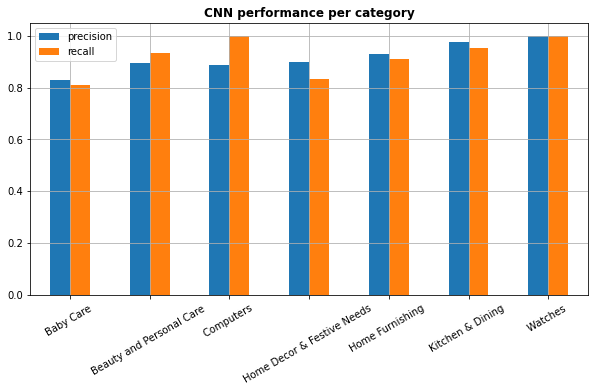

In [45]:
# Plotting scores
report = classification_report(y_test_nb.values.argmax(axis = 1),
                               y_pred_nb.argmax(axis = 1),
                               output_dict = True)

df_report = pd.DataFrame(report).iloc[:2,:7]
df_report.columns = y_.columns

df_report.T.plot(kind = 'bar', figsize = (10,5), rot = 30)
plt.title('CNN performance per category', fontweight = 'bold')
plt.grid(True)
plt.show()

# CNN on RGB images

In [28]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input

save_path = '/content/drive/My Drive/DS_projet6/Edited_Images_RGB300/'

# Creating image collection
for i in range(len(data)):
    img = load_img(save_path + data['image'][i], target_size=(300, 300))
    img = img_to_array(img)
    
    if i == 0:
        img_collec_rgb = img
    else:
        img_collec_rgb = np.append(img_collec_rgb, img)

img_collec_rgb = img_collec_rgb.reshape((len(data), 300, 300, 3))

In [32]:
# Train - test split
from sklearn.model_selection import train_test_split

y_ = pd.get_dummies(data['category'])
X_train_rgb, X_test_rgb, y_train_rgb, y_test_rgb = train_test_split(img_collec_rgb, y_, test_size = 0.3)

In [33]:
# Training model
new_model.fit(X_train_rgb, y_train_rgb, 
              batch_size = 100, 
              epochs = 20, 
              validation_split = 0.2)

Epoch 1/20
6/6 [==============================] - 9s 1s/step - loss: 2.2284 - accuracy: 0.9473 - val_loss: 1.7029 - val_accuracy: 0.9524
Epoch 2/20
6/6 [==============================] - 9s 1s/step - loss: 0.4450 - accuracy: 0.9762 - val_loss: 1.7317 - val_accuracy: 0.9388
Epoch 3/20
6/6 [==============================] - 9s 1s/step - loss: 0.1546 - accuracy: 0.9915 - val_loss: 1.8257 - val_accuracy: 0.9456
Epoch 4/20
6/6 [==============================] - 9s 1s/step - loss: 0.0813 - accuracy: 0.9864 - val_loss: 1.8023 - val_accuracy: 0.9456
Epoch 5/20
6/6 [==============================] - 9s 1s/step - loss: 0.0729 - accuracy: 0.9949 - val_loss: 1.2185 - val_accuracy: 0.9660
Epoch 6/20
6/6 [==============================] - 9s 1s/step - loss: 0.0098 - accuracy: 0.9983 - val_loss: 1.1603 - val_accuracy: 0.9592
Epoch 7/20
6/6 [==============================] - 9s 1s/step - loss: 1.0799e-04 - accuracy: 1.0000 - val_loss: 1.1211 - val_accuracy: 0.9524
Epoch 8/20
6/6 [=====================

In [34]:
# Model performance
from sklearn.metrics import classification_report
y_pred_rgb = new_model.predict(X_test_rgb)

print(classification_report(y_test_rgb.values.argmax(axis = 1), y_pred_rgb.argmax(axis = 1)))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87        40
           1       0.95      0.93      0.94        56
           2       0.89      1.00      0.94        42
           3       0.95      0.91      0.93        44
           4       0.95      0.86      0.90        49
           5       0.97      0.95      0.96        40
           6       0.98      1.00      0.99        44

    accuracy                           0.93       315
   macro avg       0.93      0.93      0.93       315
weighted avg       0.94      0.93      0.93       315



In [37]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(
    confusion_matrix(
        y_test_rgb.values.argmax(axis = 1),
        y_pred_rgb.argmax(axis=1)),
    index = y_.columns,
    columns = y_.columns)

,Baby Care,Beauty and Personal Care,Computers,Home Decor & Festive Needs,Home Furnishing,Kitchen & Dining,Watches
Baby Care,36,1,1,1,1,0,0
Beauty and Personal Care,0,52,2,1,1,0,0
Computers,0,0,42,0,0,0,0
Home Decor & Festive Needs,2,1,0,40,0,0,1
Home Furnishing,5,0,1,0,42,1,0
Kitchen & Dining,0,1,1,0,0,38,0
Watches,0,0,0,0,0,0,44


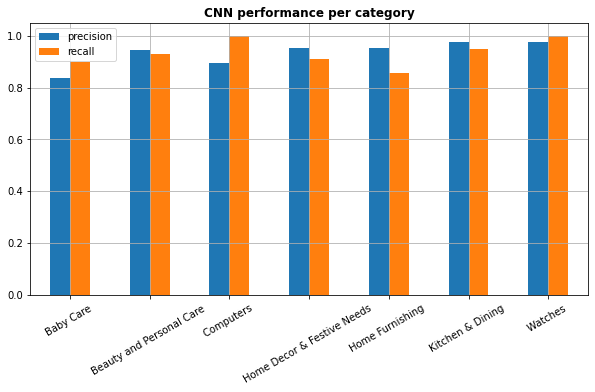

In [38]:
# Plotting scores
report = classification_report(y_test_rgb.values.argmax(axis = 1),
                               y_pred_rgb.argmax(axis = 1),
                               output_dict = True)

df_report = pd.DataFrame(report).iloc[:2,:7]
df_report.columns = y_.columns

df_report.T.plot(kind = 'bar', figsize = (10,5), rot = 30)
plt.title('CNN performance per category', fontweight = 'bold')
plt.grid(True)
plt.show()